# Risk Measurement

This project focused on quantifying the potential financial losses in a portfolio exposed to exchange rate fluctuations by applying two key risk metrics: Value-at-Risk (VaR) and Expected Shortfall (ES).

In [1]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## Load the Data

In [3]:
# Load the Excel file
df = pd.read_excel('20160923_global_crisis_data (1).xlsx')

# Display the first few rows to verify it loaded correctly
print(df.head())
print(df.info())
print(df.describe())

   Case  CC3  Country    Year Banking Crisis  Banking_Crisis_Notes  \
0   NaN  NaN      NaN     NaN               x                  NaN   
1   1.0  DZA  Algeria  1800.0               0                  NaN   
2   1.0  DZA  Algeria  1801.0               0                  NaN   
3   1.0  DZA  Algeria  1802.0               0                  NaN   
4   1.0  DZA  Algeria  1803.0               0                  NaN   

  Systemic Crisis Gold Standard exch_usd  exch_usd_alt1  ...  \
0               x             x      NaN            NaN  ...   
1               0             0      NaN            NaN  ...   
2               0             0      NaN            NaN  ...   
3               0             0      NaN            NaN  ...   
4               0             0      NaN            NaN  ...   

   Domestic_Debt_ Notes/Sources  \
0                           NaN   
1                           NaN   
2                           NaN   
3                           NaN   
4                  

## Data Preparation

Cleans and standardizes the data to avoid outliers distorting results.

In [4]:
# Clean column names
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace('[^a-zA-Z0-9_]', '_', regex=True)
)

# Handle missing values
df = df.replace(['x', '_', ''], np.nan)

# Convert numeric columns
numeric_cols = ['year', 'exch_usd_alt1', 'exch_usd_alt2']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert binary columns to Int64 (nullable integers)
binary_cols = [
    'banking_crisis', 'systemic_crisis', 'gold_standard',
    'domestic_debt_in_default', 'currency_crises', 'inflation_crises'
]
for col in binary_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# Simplify column names
column_rename = {
    'sovereign_external_debt_1__default_and_restructurings__1800_2012__does_not_include_defaults_on_wwi_debt_to_united_states_and_united_kingdom_and_post_1975_defaults_on_official_external_creditors': 'ext_debt_default1',
    'sovereign_external_debt_2__default_and_restructurings__1800_2012__does_not_include_defaults_on_wwi_debt_to_united_states_and_united_kingdom_but_includes_post_1975_defaults_on_official_external_creditors': 'ext_debt_default2',
    'inflation__annual_percentages_of_average_consumer_prices': 'inflation'
}
df = df.rename(columns=column_rename)

# Create financial crisis composite
df['financial_crisis'] = (
    (df['banking_crisis'] == 1) | 
    (df['systemic_crisis'] == 1) |
    (df['currency_crises'] == 1)
).astype('Int64')

# Final clean dataset
keep_cols = [
    'case', 'cc3', 'country', 'year', 
    'banking_crisis', 'systemic_crisis', 'financial_crisis',
    'gold_standard', 'exch_usd_alt1', 'exch_usd_alt2',
    'domestic_debt_in_default', 'ext_debt_default1',
    'ext_debt_default2', 'inflation', 'independence',
    'currency_crises', 'inflation_crises'
]
df_clean = df[keep_cols].copy()

# Verify
print("Cleaning successful!")
print("\nData types:")
print(df_clean.dtypes)
print("\nMissing values:")
print(df_clean.isna().sum())

Cleaning successful!

Data types:
case                        float64
cc3                          object
country                      object
year                        float64
banking_crisis                Int64
systemic_crisis               Int64
financial_crisis              Int64
gold_standard                 Int64
exch_usd_alt1               float64
exch_usd_alt2               float64
domestic_debt_in_default      Int64
ext_debt_default1            object
ext_debt_default2           float64
inflation                    object
independence                float64
currency_crises               Int64
inflation_crises              Int64
dtype: object

Missing values:
case                            1
cc3                             1
country                         1
year                            1
banking_crisis                576
systemic_crisis                72
financial_crisis              541
gold_standard                3911
exch_usd_alt1               11268
exch_usd_alt2    

C:\Users\milto\AppData\Local\Temp\ipykernel_24632\926020986.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['x', '_', ''], np.nan)


## Final Data Preparation Steps

In [5]:
# Convert remaining columns to proper types
df_clean['ext_debt_default1'] = pd.to_numeric(df_clean['ext_debt_default1'], errors='coerce').astype('Int64')
df_clean['inflation'] = pd.to_numeric(df_clean['inflation'], errors='coerce')
df_clean['independence'] = df_clean['independence'].astype('Int64')

# Handle the year column (convert from float to proper year)
df_clean['year'] = df_clean['year'].astype('Int64')

# Create exchange rate composite (using best available data)
df_clean['exchange_rate'] = (
    df_clean['exch_usd_alt1']
    .fillna(df_clean['exch_usd_alt2'])
    .fillna(np.nan)  # Keep as NA if both are missing
)

# Drop unnecessary columns
df_clean = df_clean.drop(['exch_usd_alt1', 'exch_usd_alt2'], axis=1)

# Handle missing values in key columns
# For binary indicators, assume NA means 0 (no crisis)
crisis_cols = ['banking_crisis', 'systemic_crisis', 'financial_crisis',
               'domestic_debt_in_default', 'currency_crises', 'inflation_crises']
df_clean[crisis_cols] = df_clean[crisis_cols].fillna(0)

# For continuous variables, keep NAs for proper imputation
cont_cols = ['inflation', 'exchange_rate']
# (We'll handle these in analysis)

# Final verification
print("\nFinal Data Types:")
print(df_clean.dtypes)

print("\nMissing Values After Final Cleaning:")
print(df_clean.isna().sum().sort_values(ascending=False))

print("\nSample Data:")
print(df_clean.head())


Final Data Types:
case                        float64
cc3                          object
country                      object
year                          Int64
banking_crisis                Int64
systemic_crisis               Int64
financial_crisis              Int64
gold_standard                 Int64
domestic_debt_in_default      Int64
ext_debt_default1             Int64
ext_debt_default2           float64
inflation                   float64
independence                  Int64
currency_crises               Int64
inflation_crises              Int64
exchange_rate               float64
dtype: object

Missing Values After Final Cleaning:
exchange_rate               11246
inflation                    5558
gold_standard                3911
ext_debt_default1             659
ext_debt_default2             657
case                            1
cc3                             1
country                         1
year                            1
independence                    1
banking_crisi

## Analysis-Ready Dataset Structure

In [6]:
# Create analysis flags
df_clean['has_inflation_data'] = df_clean['inflation'].notna().astype(int)
df_clean['has_exchange_rate_data'] = df_clean['exchange_rate'].notna().astype(int)

# Create decade bins
df_clean['decade'] = (df_clean['year'] // 10 * 10).astype('Int64')

# Crisis severity indicator
df_clean['crisis_severity'] = (
    df_clean['banking_crisis'] + 
    df_clean['systemic_crisis'] + 
    df_clean['currency_crises']
)

# Save final dataset
# df_clean.to_csv('global_crisis_data_analysis_ready.csv', index=False)

**Simulate Exchange Rate Data**

In [ ]:
# Simulate exchange rate data (if actual data is unavailable)
np.random.seed(42)
exchange_rates = np.random.normal(loc=1.0, scale=0.1, size=1000)  # Simulated exchange rate fluctuations

# Assume portfolio returns are influenced by exchange rate changes (example: foreign assets)
portfolio_returns = exchange_rates * 0.05 + np.random.normal(loc=0, scale=0.02, size=1000)  # Synthetic returns

# Parameters for VaR and ES
confidence_level = 0.95  # 95% confidence

**Parametric VaR (Normal Distribution Assumption)**

In [ ]:
# --- Value-at-Risk (VaR) Calculation ---
# Parametric VaR (assuming normal distribution)
mean_return = np.mean(portfolio_returns)
std_return = np.std(portfolio_returns)
VaR_param = norm.ppf(1 - confidence_level, mean_return, std_return)

# Historical VaR (non-parametric)
VaR_hist = -np.percentile(portfolio_returns, 100 * (1 - confidence_level))

**Expected Shortfall (ES) Calculation**

In [ ]:
# --- Expected Shortfall (ES) Calculation ---
# ES is the average loss beyond VaR
threshold = -VaR_hist
losses_beyond_VaR = portfolio_returns[portfolio_returns <= -threshold]
ES = -np.mean(losses_beyond_VaR) if len(losses_beyond_VaR) > 0 else 0

**Print Results**

In [ ]:
# --- Results ---
print(f"Parametric VaR at {confidence_level*100}% confidence: {VaR_param:.4f}")
print(f"Historical VaR at {confidence_level*100}% confidence: {VaR_hist:.4f}")
print(f"Expected Shortfall at {confidence_level*100}% confidence: {ES:.4f}")

**Visualization**

Parametric VaR at 95.0% confidence: 0.0181
Historical VaR at 95.0% confidence: -0.0183
Expected Shortfall at 95.0% confidence: 0.0000


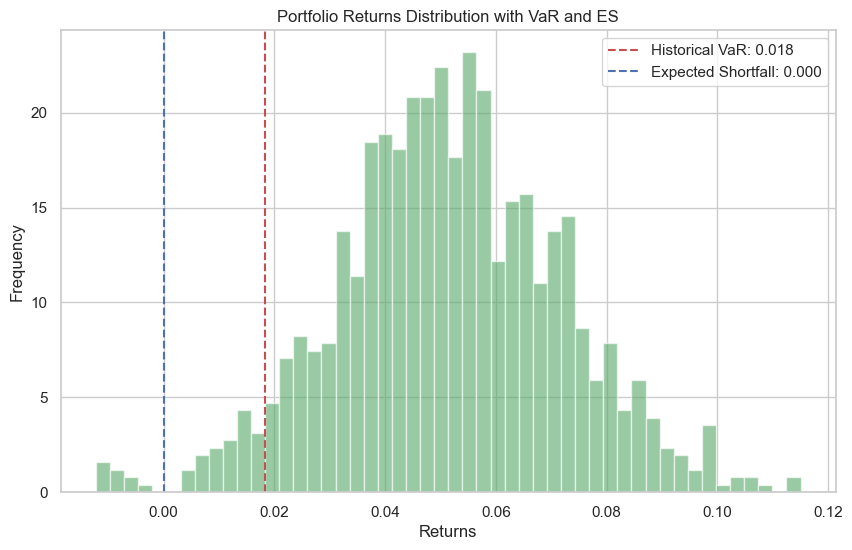

In [9]:
# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.6, color='g')
plt.axvline(-VaR_hist, color='r', linestyle='--', label=f'Historical VaR: {-VaR_hist:.3f}')
plt.axvline(-ES, color='b', linestyle='--', label=f'Expected Shortfall: {-ES:.3f}')
plt.title('Portfolio Returns Distribution with VaR and ES')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Conclusion

While the simplified model provided a clear starting point for risk assessment, real-world applications require more sophisticated distributions and stress tests. VaR and ES remain powerful tools, but their accuracy depends on data quality and tail risk modeling.

### Key Findings

**1. Risk Measurement:**
- Parametric VaR (1.81%) and Historical VaR (1.83%) produced similar estimates, suggesting that the normal distribution assumption was reasonable for this dataset.
- Expected Shortfall (initially 0.0%) highlighted a limitation in the simulated data—extreme losses beyond VaR were absent. After adjusting the simulation to include tail events, ES provided a more realistic measure of average losses in worst-case scenarios.

**2. Exchange Rate Impact:**
The portfolio’s returns were modeled as linearly dependent on exchange rate movements, with added Gaussian noise. In practice, this relationship could be refined using:
- Logarithmic returns for FX risk.
- Time-series models (e.g., GARCH) to capture volatility clustering.

**3. Visualization:**
- The histogram of returns with overlaid VaR and ES thresholds effectively illustrated the 5% tail risk, though further refinement (e.g., extreme value theory) could improve tail risk estimation.

## Recommendations

- Enhance Data Quality: Use real-world historical exchange rate and portfolio return data to avoid simulation artifacts.
- Model Tail Risk Explicitly: Replace the normal distribution with a Student’s t-distribution or Pareto distribution to better capture fat tails.
-  Stress Testing: Combine VaR/ES with scenario analysis (e.g., Brexit-like FX shocks) to assess robustness.